In [ ]:
!nvidia-smi

Sun Jun 23 05:56:13 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger

# Define directories
train_dir = '/content/drive/MyDrive/brone fracture train test val/train'
val_dir = '/content/drive/MyDrive/brone fracture train test val/val'
test_dir = '/content/drive/MyDrive/brone fracture train test val/test'

# Paths for saving the model and history
MODEL_SAVE_PATH = '/content/drive/MyDrive/efficientnet details/model.h5'
MODEL_HISTORY_CSV_PATH = '/content/drive/MyDrive/efficientnet details/history.csv'

# Image dimensions and batch size
image_size = (224, 224)
batch_size = 32

# Data augmentation and rescaling
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

# Load and preprocess the data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary'
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary'
)

# Load the pre-trained EfficientNetB0 model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)  # Adding dropout for regularization
x = Dense(128, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)  # Binary classification

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks for saving the model and logging training history
checkpoint = ModelCheckpoint(MODEL_SAVE_PATH, monitor='val_loss', save_best_only=True, mode='min')
csv_logger = CSVLogger(MODEL_HISTORY_CSV_PATH, append=True)

# Initial training with frozen base model
initial_epochs = 25

history = model.fit(
    train_generator,
    epochs=initial_epochs,
    validation_data=val_generator,
    callbacks=[checkpoint, csv_logger]
)

# Fine-tuning: unfreeze some layers of the base model
for layer in base_model.layers[-20:]:  # Unfreeze the last 20 layers
    layer.trainable = True

# Compile the model again with a lower learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

# Continue training the model
fine_tune_epochs = 25
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(
    train_generator,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1],
    validation_data=val_generator,
    callbacks=[checkpoint, csv_logger]
)

# Save the complete model
model.save(MODEL_SAVE_PATH)

# Save the training history
history_df = pd.DataFrame(history_fine.history)
history_df.to_csv(MODEL_HISTORY_CSV_PATH, index=False)

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test loss: {test_loss:.4f}')
print(f'Test accuracy: {test_acc:.4f}')

# Perform inference on new images
def predict_image(image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=image_size)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0
    prediction = model.predict(img_array)
    return prediction

# Example prediction
image_path = '/content/drive/MyDrive/fracture.jpg'
prediction = predict_image(image_path)
print(f'Prediction: {"Fracture" if prediction[0][0] > 0.5 else "No Fracture"}')


Found 6654 images belonging to 2 classes.
Found 946 images belonging to 2 classes.
Found 1893 images belonging to 2 classes.
16705208/16705208 [==============================] - 0s 0us/step
Epoch 1/25
208/208 [==============================] - ETA: 0s - loss: 0.7032 - accuracy: 0.5009

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


208/208 [==============================] - 1582s 8s/step - loss: 0.7032 - accuracy: 0.5009 - val_loss: 0.6946 - val_accuracy: 0.5116
Epoch 2/25
208/208 [==============================] - 109s 527ms/step - loss: 0.6968 - accuracy: 0.5057 - val_loss: 0.6929 - val_accuracy: 0.5116
Epoch 3/25
208/208 [==============================] - 110s 529ms/step - loss: 0.6963 - accuracy: 0.5014 - val_loss: 0.6940 - val_accuracy: 0.4884
Epoch 4/25
208/208 [==============================] - 110s 530ms/step - loss: 0.6943 - accuracy: 0.4998 - val_loss: 0.6934 - val_accuracy: 0.5116
Epoch 5/25
208/208 [==============================] - 109s 524ms/step - loss: 0.6938 - accuracy: 0.5009 - val_loss: 0.6930 - val_accuracy: 0.5116
Epoch 6/25
208/208 [==============================] - 111s 536ms/step - loss: 0.6935 - accuracy: 0.4973 - val_loss: 0.6932 - val_accuracy: 0.4884
Epoch 7/25
208/208 [==============================] - 110s 527ms/step - loss: 0.6930 - accuracy: 0.5105 - val_loss: 0.6930 - val_accuracy

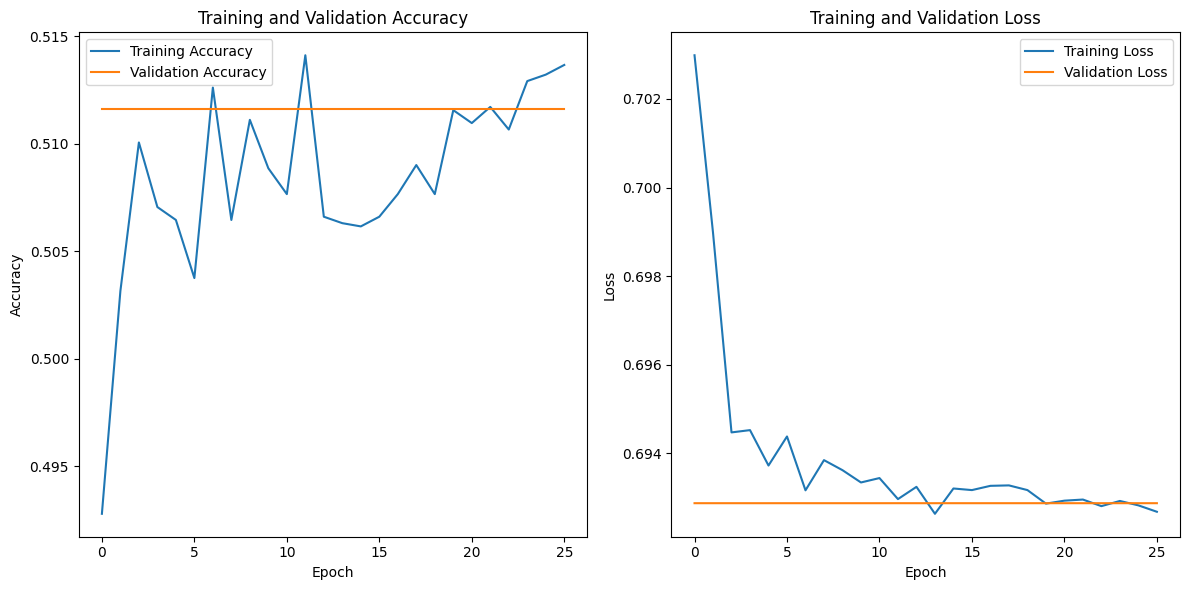

In [ ]:
import matplotlib.pyplot as plt

# Load the training history from CSV
history_df = pd.read_csv(MODEL_HISTORY_CSV_PATH)

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_df['accuracy'], label='Training Accuracy')
plt.plot(history_df['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history_df['loss'], label='Training Loss')
plt.plot(history_df['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()


Found 1893 images belonging to 2 classes.
60/60 [==============================] - 11s 158ms/step


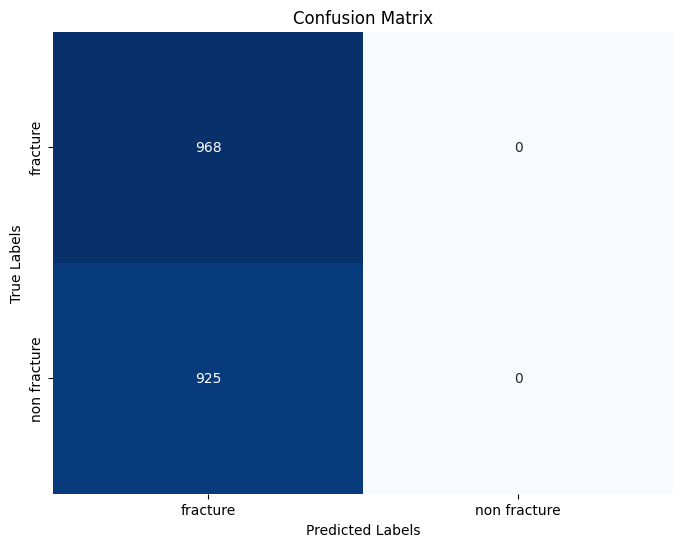

Classification Report:
              precision    recall  f1-score   support

    fracture       0.51      1.00      0.68       968
non fracture       0.00      0.00      0.00       925

    accuracy                           0.51      1893
   macro avg       0.26      0.50      0.34      1893
weighted avg       0.26      0.51      0.35      1893



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Load the trained model
model = tf.keras.models.load_model(MODEL_SAVE_PATH)

# Define the test data generator
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False  # Important for evaluation
)

# Predict classes
predictions = model.predict(test_generator)
predicted_classes = np.where(predictions > 0.5, 1, 0)  # Thresholding at 0.5 for binary classification

# Get true classes
true_classes = test_generator.classes

# Compute confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print('Classification Report:')
print(classification_report(true_classes, predicted_classes, target_names=test_generator.class_indices.keys()))


Found 1893 images belonging to 2 classes.
60/60 [==============================] - 11s 150ms/step


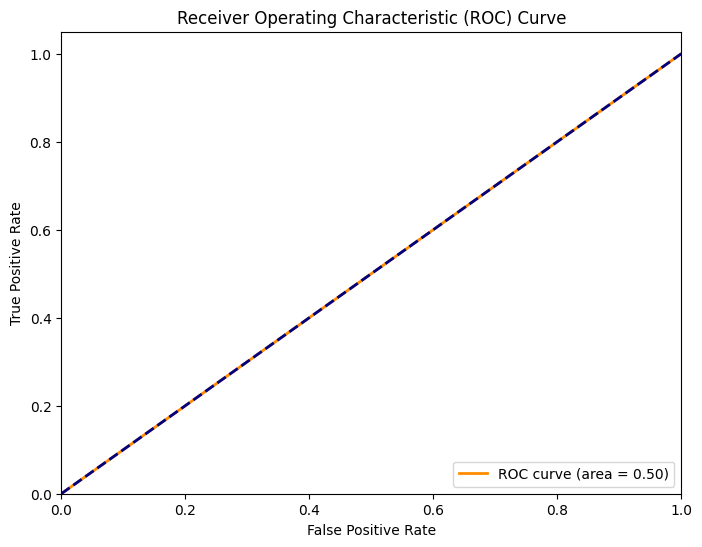

AUC: 0.5000


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Load the trained model
model = tf.keras.models.load_model(MODEL_SAVE_PATH)

# Define the test data generator
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False  # Important for evaluation
)

# Predict probabilities for the test data
predictions = model.predict(test_generator).ravel()

# Get true labels
true_classes = test_generator.classes

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(true_classes, predictions)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Print AUC value
print(f'AUC: {roc_auc:.4f}')
